In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os.path import join
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
cambodia_file = r'joinedDataCambodia.csv'
vietnam_file = r'joinedDataVietnam.csv'
merged_file = r'mergedData.csv'

clusters_folder="Clusters"

cambodia_csv = pd.read_csv(os.path.join(directory, 'Game Data', cambodia_file), engine="python")
vietnam_csv = pd.read_csv(os.path.join(directory, 'Game Data', vietnam_file), engine='python')
merged_csv = pd.read_csv(os.path.join(directory, 'Game Data', merged_file), engine='python')

rgb_colors = [
    (215, 50, 41),     # Base
    (44, 209, 59),    # NCH
    (237, 237, 49),
    (45, 141, 190),     # Base
]
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def to_percentage(x, pos):
    return f'{x * 100:.0f}%'


In [2]:
# 4 clusters based on cell type
# # labels_full=labels
labels_full_vietnam=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_vietnam.csv")))
labels_full_vietnam=np.array([arr[0] for arr in labels_full_vietnam])
centers_vietnam=np.array(pd.read_csv(join(directory, clusters_folder, "centers_4_cell_type_vietnam.csv")))


labels_full_cambodia=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_cambodia.csv")))
labels_full_cambodia=np.array([arr[0] for arr in labels_full_cambodia])
centers_cambodia=np.array(pd.read_csv(join (directory, clusters_folder, "centers_4_cell_type_cambodia.csv")))


labels_full_merged=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_merged.csv")))
labels_full_merged=np.array([arr[0] for arr in labels_full_merged])
centers_merged=np.array(pd.read_csv(join (directory, clusters_folder, "centers_4_cell_type_merged.csv")))

labels_2_merged=np.array(pd.read_csv(join(directory, clusters_folder, "labels_2_cell_type_merged.csv")))
labels_2_merged=np.array([arr[0] for arr in labels_2_merged])
centers_2_merged=np.array(pd.read_csv(join (directory, clusters_folder, "centers_2_cell_type_merged.csv")))

hs_labels={"Vietnam": [3], "Cambodia": [1], "Merged": [1]}
nch_labels={"Vietnam":  [1, 2], "Cambodia": [2, 3], "Merged": [2, 3]}
base_labels={"Vietnam":  [0], "Cambodia": [0], "Merged": [0]}
strategy_labels={"Vietnam":  ['Neutral', 'NCH (Moderate)', 'NCH (High)', 'Heavy Spray'], 
                 "Cambodia": ['Neutral', 'Heavy Spray', 'NCH (Moderate)', 'NCH (High)'],
                 "Merged": ['Neutral', 'Heavy Spray', 'NCH (High)', 'NCH (Moderate)']}

def set_country(curr_str):
    global curr_csv
    global hs_label
    hs_label=hs_labels[curr_str]
    global nch_label
    nch_label=nch_labels[curr_str]
    global base_label
    base_label=base_labels[curr_str]
    global strategy_label
    strategy_label=strategy_labels[curr_str]
    global labels_full
    global centers
    # for 2 clusters
    global labels_2, centers_2, nch_2, hs_2

    nch_2=0
    hs_2=1

    if curr_str == "Merged":
        labels_full= labels_full_merged
        centers = centers_merged
        curr_csv = merged_csv
        labels_2=labels_2_merged
        centers_2=centers_2_merged
        nch_2=0
        hs_2=1

    elif curr_str == "Vietnam":
        labels_full= labels_full_vietnam
        centers = centers_vietnam
        curr_csv = vietnam_csv
        labels_2=labels_2_merged[:4480*4]
        centers_2=centers_2_merged[:4480*4]
        # labels_2=labels_2_vietnam
        # centers_2=centers_2_vietnam
        # nch_2=1
        # hs_2=0
    elif curr_str == "Cambodia":
        labels_full= labels_full_cambodia
        centers = centers_cambodia
        curr_csv = cambodia_csv
        labels_2=labels_2_merged[4480*4:]
        centers_2=centers_2_merged[4480*4:]
        # labels_2=labels_2_cambodia
        # centers_2=centers_2_cambodia
        # nch_2=1
        # hs_2=0

def calculate_score_csv(row_num, curr_csv):
    plot=np.array(curr_csv.iloc[row_num, 40:76]).reshape(6,6)
    cell_yield=[5, 0, 6, 10]
    
    scores=np.zeros((6, 6))
    if curr_csv['numNCH'][row_num] == 0:
        subsidy = 0
    else:
        subsidy = curr_csv['sumSubsidies'][row_num]/curr_csv['numNCH'][row_num]

    cell_yield[1]=subsidy

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield

def calculate_score(board, subsidy):
    plot=np.array(board).reshape(6,6)
    cell_yield=[5, 0, 6, 10]
    # print(plot)
    scores=np.zeros((6, 6))

    cell_yield[1]=subsidy

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield


def calculate_net_yield(board):
    # plot=np.array(curr_csv.iloc[row_num, 40:76]).reshape(6,6)
    plot = np.array(board).reshape(6, 6)
    cell_yield=[5, 0, 6, 10]
    # print(plot)
    scores=np.zeros((6, 6))

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield


def calculate_nch(board):
    # plot = np.array(curr_csv.iloc[row_num, 40:76]).reshape(6, 6)
    plot = np.array(board).reshape(6, 6)
    # cell_yield = [5, 0, 6, 10]
    nch_nums = [0, 0, 0]
    # print(plot)
    scores = np.zeros((6, 6))

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz] == 1 or plot[vert, horiz] == 3:
                            continue
                        scores[vert, horiz] += 2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        nch_nums[0]+=scores[vert, horiz]
                        scores[vert, horiz] = 0

    for row in range(6):
        for col in range(6):
            nch_nums[1] += scores[row, col]
            if plot[row, col] == 1:
                nch_nums[2]+=1

    #[cancelled, bonus, num cells]
    return nch_nums
    
cells_map=np.zeros((6, 6)).tolist()
for i in range(6):
    for j in range(6):
        if i<3 and j<3:
            cells_map[i][j]=1
        elif i>=3 and j<3:
            cells_map[i][j]=4
        elif i<3 and j>=3:
            cells_map[i][j]=2
        else:
            cells_map[i][j]=3

In [11]:
plt.rcParams.update({'font.size': 16}) # label font size
title_size=18 # title font size
padding_title_size=20 # padding between title and rest of figure
legend_size=14 # size of legend text

# K-means Clustering Farms by Patches

In [3]:
#updated 3 cluster based on cell type
set_country("Merged")

X = []

curr_round = [0 for i in range(36)]

for i in range(len(curr_csv)):

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corner = np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)

        cell_types = [0 for i in range(4)]
        for k in corner.flatten():
            cell_types[k] += 1

        addon = np.array([[0 for k in range(3)] for l in range(3)])
        for row in range(3):
            for col in range(3):
                if corner[row][col] == 1:
                    for a in range(3):
                        for b in range(3):
                            if corner[a, b] != 1:
                                addon[a, b] += 2

        self_canceled = 0
        for row in range(3):
            for col in range(3):
                if corner[row][col] == 3:
                    for a in range(max(0, row-1), min(3, row+2)):
                        for b in range(max(0, col-1), min(3, col+2)):
                            self_canceled += addon[a, b]
                            addon[a, b] = 0

        self_benefit = 0
        for row in range(3):
            for col in range(3):
                self_benefit += addon[row, col]

        if curr_csv['numNCH'][i] == 0:
            subsidy = 0
        else:
            subsidy = curr_csv['sumSubsidies'][i]/curr_csv['numNCH'][i]

        header_str = "Player"+str(j+1)+"_Net_Yield"
        X.append([cell_types[1]/9, cell_types[3]/9, (cell_types[0]+cell_types[2])/9])


X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
X_scaled

array([[-0.06748162,  0.09537831, -0.07705781],
       [-0.80626854,  0.38315769, -0.07705781],
       [ 1.41009223, -0.48018045, -0.07705781],
       ...,
       [-0.80626854,  1.24649582, -1.03992957],
       [-0.80626854, -0.48018045,  0.88581395],
       [ 0.67130531,  1.24649582, -1.68184408]])

In [15]:
X

array([[0.11111111, 0.33333333, 0.55555556],
       [0.        , 0.44444444, 0.55555556],
       [0.33333333, 0.11111111, 0.55555556],
       ...,
       [0.        , 0.77777778, 0.22222222],
       [0.        , 0.11111111, 0.88888889],
       [0.22222222, 0.77777778, 0.        ]])

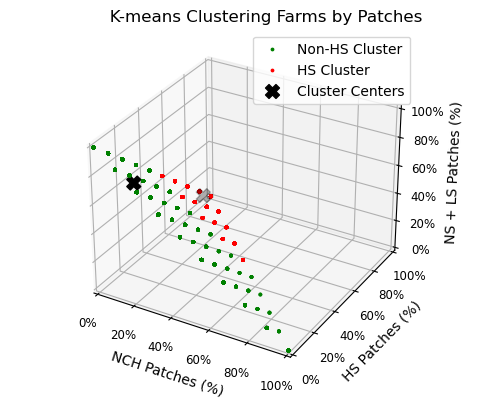

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

set_country("Merged")
num = 2
kmeans = KMeans(n_clusters=num)

# labels_temp = kmeans.fit_predict(X_scaled)
labels_temp=labels_2
centers_temp=centers_2/9

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

clusters_arr=['Non-HS Cluster', 'HS Cluster']

# Scatter plot the data points by cluster label
colors=['green', 'red']
for i in range(num):
    ax.scatter(X[labels_temp == i, 0], X[labels_temp == i, 1],
               X[labels_temp == i, 2], label=clusters_arr[i], s=3, c=colors[i])

# Scatter plot the cluster centers
ax.scatter(centers_temp[:, 0], centers_temp[:, 1], centers_temp[:, 2],
           c='black', marker='X', s=100, label='Cluster Centers')

# Set labels and title
ax.set_xlabel('NCH Patches (%)')
ax.set_ylabel('HS Patches (%)')
# ax.zaxis.labelpad = 100000
ax.set_zlabel('NS + LS Patches (%)')
ax.set_title('                   K-means Clustering Farms by Patches          ')

# Add a legend
ax.legend()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.tick_params(axis='x', labelsize=8.5)
ax.tick_params(axis='y', labelsize=8.5)
ax.tick_params(axis='z', labelsize=8.5)
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percentage))
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))
plt.gca().zaxis.set_major_formatter(FuncFormatter(to_percentage))


# Display the plot
plt.tight_layout()
plt.savefig(join(directory, 'Figures', 'kmeans_3d.png'), dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
cluster_df=pd.concat([pd.DataFrame(labels_2), pd.DataFrame(X)], axis=1)
cluster_df.columns=['Cluster', 'NCH Cells', 'HS Cells', 'NS + LS Cells']
std_devs = cluster_df.groupby('Cluster').std()

print("Standard Deviations of Features in Each Cluster:\n", std_devs)

Standard Deviations of Features in Each Cluster:
          NCH Cells  HS Cells  NS + LS Cells
Cluster                                    
0         0.157147  0.123181       0.178946
1         0.059621  0.149193       0.134595


# Davies-Bouldin Index

For n_clusters=2, the Davies-Bouldin index is 0.37993122376167315
For n_clusters=3, the Davies-Bouldin index is 0.8154936087176997
For n_clusters=4, the Davies-Bouldin index is 0.6916835832602942
For n_clusters=5, the Davies-Bouldin index is 0.6996234600701831
For n_clusters=6, the Davies-Bouldin index is 0.6570955521831846
For n_clusters=7, the Davies-Bouldin index is 0.6894669916503843
For n_clusters=8, the Davies-Bouldin index is 0.6627730797433208
For n_clusters=9, the Davies-Bouldin index is 0.6654051149052944
For n_clusters=10, the Davies-Bouldin index is 0.6960539842845307


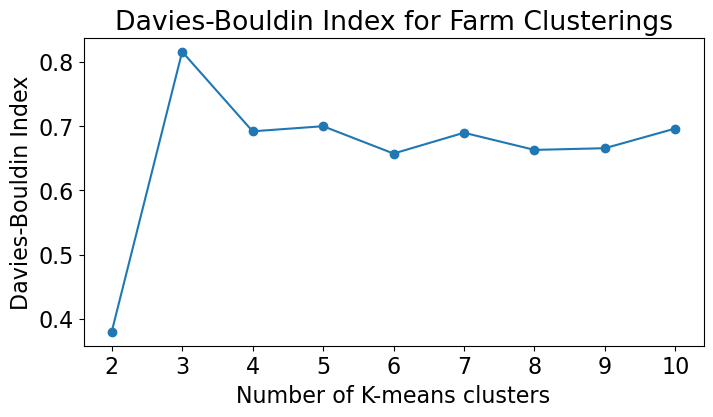

In [5]:
plt.rcParams.update({'font.size': 16})
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np

dbi = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    kmeans.fit_predict(X)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(X, labels)
    dbi.append(db_index)
    print(f"For n_clusters={i}, the Davies-Bouldin index is {db_index}")

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), dbi, marker='o')
plt.title('Davies-Bouldin Index for Farm Clusterings')
plt.xlabel('Number of K-means clusters')
plt.ylabel('Davies-Bouldin Index')
plt.savefig(join(directory, 'Figures', 'davies-bouldin.png'), dpi=600, bbox_inches='tight')
plt.show()


# Patch Changes After Strategy Switch

[-1.0204461  -0.53531599 -3.2732342   4.82899628]


Text(0.5, 1.0, 'Patch Changes After Strategy Switch (Non-HS to HS)')

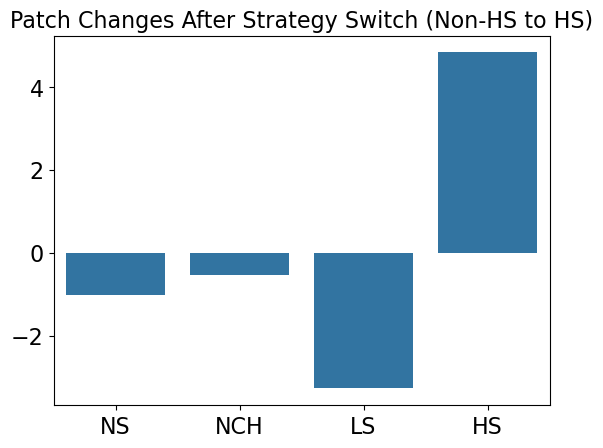

In [ ]:

X=[]
Y=[]
set_country("Merged")

decrease=[0]*4
total=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'][i+1] == 1:
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    next_plot = np.array(curr_csv.iloc[i+1, 40:76]).reshape(6,6)

    for j in range(4):
        if labels_2[(i)*4+j]==nch_2 and labels_2[(i+1)*4+j]==hs_2:
            total+=1
            
            corner=np.array(plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3])
            for row in range(3):
                for col in range(3):
                    decrease[corner[row, col]]-=1

            corner=np.array(next_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3])
            for row in range(3):
                for col in range(3):
                    decrease[corner[row, col]]+=1
for i in range(4):
    decrease[i]/=total
print(np.array(decrease))
cells=['NS', 'NCH', 'LS', 'HS']
sns.barplot(x=cells, y=decrease)
plt.title("Patch Changes After Strategy Switch (Non-HS to HS)", fontsize=16)
plt.savefig(join(directory, 'Figures', 'cell_changes_non-hs_to_hs.png'), dpi=600, bbox_inches='tight')

[ 1.1902497   0.57312723  3.22473246 -4.98810939]


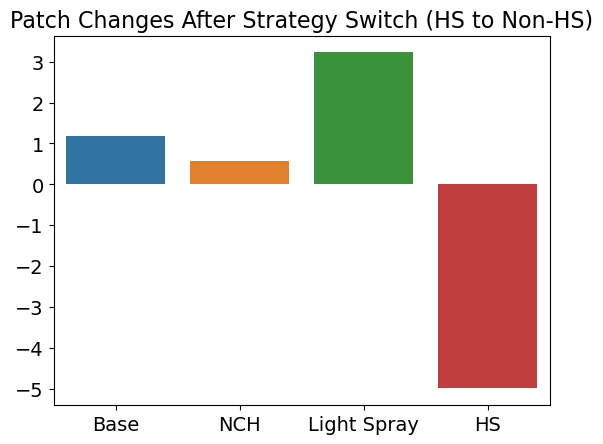

In [ ]:

X=[]
Y=[]
set_country("Merged")

decrease=[0]*4
total=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'][i+1] == 1:
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    next_plot = np.array(curr_csv.iloc[i+1, 40:76]).reshape(6,6)

    for j in range(4):
        if labels_2[(i)*4+j]==hs_2 and labels_2[(i+1)*4+j]!=hs_2:
            total+=1
            
            corner=np.array(plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3])
            for row in range(3):
                for col in range(3):
                    decrease[corner[row, col]]-=1

            corner=np.array(next_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3])
            for row in range(3):
                for col in range(3):
                    decrease[corner[row, col]]+=1
for i in range(4):
    decrease[i]/=total
print(np.array(decrease))
plt.yticks([_ for _ in range(-5, 4)])
cells=['Base', 'NCH', 'Light Spray', 'HS']
sns.barplot(x=cells, y=decrease)
plt.title("Patch Changes After Strategy Switch (HS to Non-HS)", fontsize=16)
plt.savefig(join(directory, 'Figures', 'cell_changes_hs_to_non-hs.png'), dpi=600, bbox_inches='tight')

# Collective strategy switching

percent of time someone defects after switching to HS strategy: 0.500507614213198
0.47509578544061304
0.5291576673866091
percent of time someone defects after switching to NCH strategy: 0.6205128205128205
0.6616161616161617
0.578125


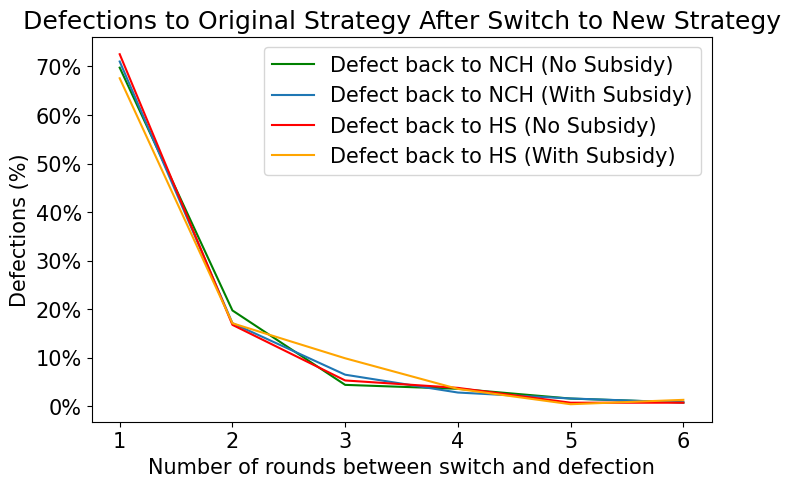

In [4]:
# tracking those who stay as well

plt.rcParams.update({'font.size': 15})
set_country("Merged")
labels_2=labels_2_merged

defections_arr=[[0]*8 for _ in range(11)]
defections=[0]*11
score_arr=[0]*11
total_switches=[0]*11
switches=0
plt_arr=[]

switch_round=[1]*4

addon=4480*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==nch_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to HS strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])

for j in range(2):
    for i in range(1, len(defections_arr[0])):
        # score_arr[i]/=defections_arr[i]
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

defections_arr=[[0]*8 for _ in range(11)]
score_arr=[0]*11
total_switches=[0]*11
switch_round=[1]*4
defections=[0]*11

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==hs_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to NCH strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])
    
for j in range(2):
    for i in range(1, len(defections_arr[0])):
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

labels=['Defect back to NCH (No Subsidy)', 'Defect back to NCH (With Subsidy)', 
        'Defect back to HS (No Subsidy)', 'Defect back to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])
for j in range(4):
    sns.lineplot(x=[_ for _ in range(1, 7)], y=plt_arr[j][:6], label=labels[j], color=colors[j])

plt.xticks([_ for _ in range(1, 7)])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Defections (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Defections to Original Strategy After Switch to New Strategy")
plt.savefig(join(directory, 'Figures', 'defections_merged.png'), dpi=600, bbox_inches='tight')

percent of time someone defects after switching to HS strategy: 0.5140449438202247
0.495
0.5384615384615384
percent of time someone defects after switching to NCH strategy: 0.5778546712802768
0.6733333333333333
0.4748201438848921


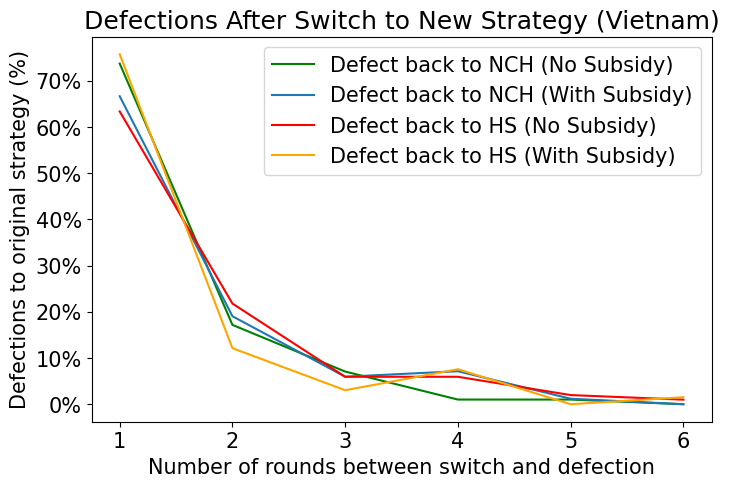

In [13]:
# tracking those who stay as well

plt.rcParams.update({'font.size': 15})
set_country("Vietnam")

defections_arr=[[0]*8 for _ in range(11)]
defections=[0]*11
score_arr=[0]*11
total_switches=[0]*11
switches=0
plt_arr=[]

switch_round=[1]*4

addon=4480*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==nch_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to HS strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])

for j in range(2):
    for i in range(1, len(defections_arr[0])):
        # score_arr[i]/=defections_arr[i]
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

defections_arr=[[0]*8 for _ in range(11)]
score_arr=[0]*11
total_switches=[0]*11
switch_round=[1]*4
defections=[0]*11

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==hs_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to NCH strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])
    
for j in range(2):
    for i in range(1, len(defections_arr[0])):
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

labels=['Defect back to NCH (No Subsidy)', 'Defect back to NCH (With Subsidy)', 
        'Defect back to HS (No Subsidy)', 'Defect back to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])
for j in range(4):
    sns.lineplot(x=[_ for _ in range(1, 7)], y=plt_arr[j][:6], label=labels[j], color=colors[j])

plt.xticks([_ for _ in range(1, 7)])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Defections to original strategy (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Defections After Switch to New Strategy (Vietnam)")
plt.savefig(join(directory, 'Figures', 'defections_vietnam.png'), dpi=600, bbox_inches='tight')

percent of time someone defects after switching to HS strategy: 0.492845786963434
0.46273291925465837
0.5244299674267101
percent of time someone defects after switching to NCH strategy: 0.6456211812627292
0.6544715447154471
0.636734693877551


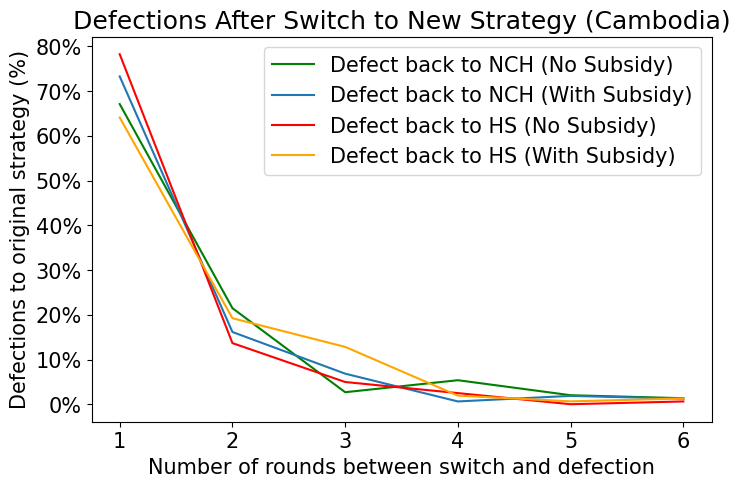

In [14]:
# tracking those who stay as well

plt.rcParams.update({'font.size': 15})
set_country("Cambodia")

defections_arr=[[0]*8 for _ in range(11)]
defections=[0]*11
score_arr=[0]*11
total_switches=[0]*11
switches=0
plt_arr=[]

switch_round=[1]*4

addon=4480*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==nch_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to HS strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])

for j in range(2):
    for i in range(1, len(defections_arr[0])):
        # score_arr[i]/=defections_arr[i]
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

defections_arr=[[0]*8 for _ in range(11)]
score_arr=[0]*11
total_switches=[0]*11
switch_round=[1]*4
defections=[0]*11

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Game'][i] == 'GP':
        switch_round=[1]*4
        continue

    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switch_round[j]=curr_csv['Round'][i+1]
                total_switches[subsidy]+=1
        else:
            if labels_2[(i+1)*4+j]==hs_2 and switch_round[j]!=1:
                defections_arr[subsidy][curr_csv['Round'][i+1]-switch_round[j]]+=1
                defections[subsidy]+=1

print("percent of time someone defects after switching to NCH strategy:", sum(defections)/sum(total_switches))
for i in range(2):
    print(defections[i]/total_switches[i])
    
for j in range(2):
    for i in range(1, len(defections_arr[0])):
        defections_arr[j][i]/=defections[j]
    plt_arr.append(defections_arr[j][1:])

labels=['Defect back to NCH (No Subsidy)', 'Defect back to NCH (With Subsidy)', 
        'Defect back to HS (No Subsidy)', 'Defect back to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])
for j in range(4):
    sns.lineplot(x=[_ for _ in range(1, 7)], y=plt_arr[j][:6], label=labels[j], color=colors[j])

plt.xticks([_ for _ in range(1, 7)])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Defections to original strategy (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Defections After Switch to New Strategy (Cambodia)")
plt.savefig(join(directory, 'Figures', 'defections_cambodia.png'), dpi=600, bbox_inches='tight')

# collective switches to same strategy

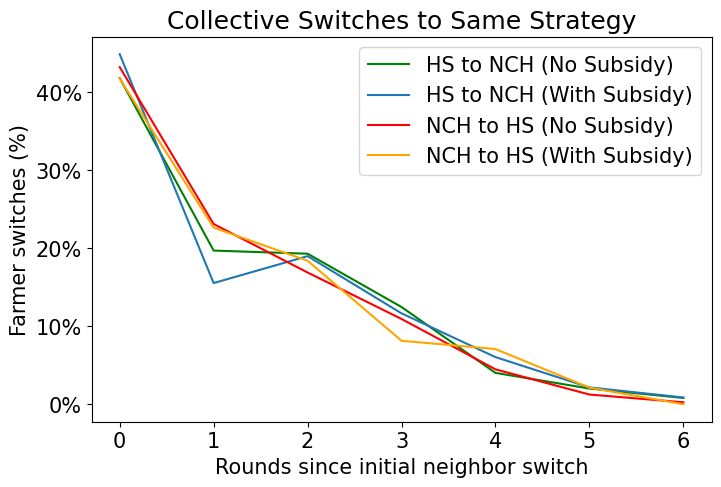

In [7]:
plt.rcParams.update({'font.size': 15})
# separating by country and subsidy
set_country("Merged")

switch_round=[0]*4
total_switches=[0]*11
switches=0
plt_arr=[[0]*7 for _ in range(4)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue 
    
    switches=0
    # subsidy=curr_csv['Subsidy'][i]
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    # curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switches+=1

    if switches>1:
        plt_arr[subsidy][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy]+=switches
        recent_switch=curr_csv['Round'][i+1]

switch_round=[0]*4
# total_switches=0
switches=0
# plt_arr=[[0]*6 for _ in range(2)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue
    switches=0
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switches+=1
    if switches>1:
        plt_arr[subsidy+2][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy+2]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy+2][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy+2]+=switches
        recent_switch=curr_csv['Round'][i+1]


for i in range(4):
    for j in range(len(plt_arr[1])):
        plt_arr[i][j]/=total_switches[i]

labels=['HS to NCH (No Subsidy)', 'HS to NCH (With Subsidy)', 'NCH to HS (No Subsidy)', 
        'NCH to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])

for i in range(4):
    sns.lineplot(x=[_ for _ in range(len(plt_arr[i]))], y=plt_arr[i], 
                 label=labels[i], color=colors[i])
plt.xlabel("Rounds since initial neighbor switch")
plt.ylabel("Farmer switches (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Collective Switches to Same Strategy")
plt.savefig(join(directory, 'Figures', 'collective_switches_merged.png'), dpi=600, bbox_inches='tight')

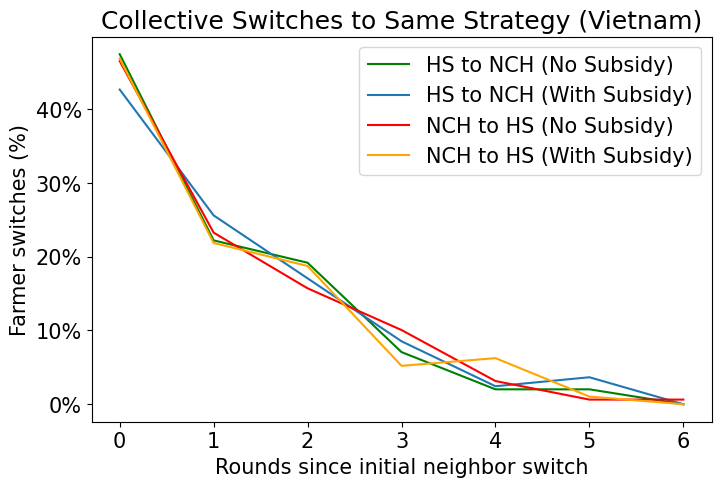

In [9]:
plt.rcParams.update({'font.size': 15})
# separating by country and subsidy
set_country("Vietnam")

switch_round=[0]*4
total_switches=[0]*11
switches=0
plt_arr=[[0]*7 for _ in range(4)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue 
    
    switches=0
    # subsidy=curr_csv['Subsidy'][i]
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    # curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switches+=1

    if switches>1:
        plt_arr[subsidy][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy]+=switches
        recent_switch=curr_csv['Round'][i+1]

switch_round=[0]*4
# total_switches=0
switches=0
# plt_arr=[[0]*6 for _ in range(2)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue
    switches=0
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switches+=1
    if switches>1:
        plt_arr[subsidy+2][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy+2]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy+2][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy+2]+=switches
        recent_switch=curr_csv['Round'][i+1]


for i in range(4):
    for j in range(len(plt_arr[1])):
        plt_arr[i][j]/=total_switches[i]

labels=['HS to NCH (No Subsidy)', 'HS to NCH (With Subsidy)', 'NCH to HS (No Subsidy)', 
        'NCH to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])

for i in range(4):
    sns.lineplot(x=[_ for _ in range(len(plt_arr[i]))], y=plt_arr[i], 
                 label=labels[i], color=colors[i])
plt.xlabel("Rounds since initial neighbor switch")
plt.ylabel("Farmer switches (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Collective Switches to Same Strategy (Vietnam)")
plt.savefig(join(directory, 'Figures', 'collective_switches_vietnam.png'), dpi=600, bbox_inches='tight')

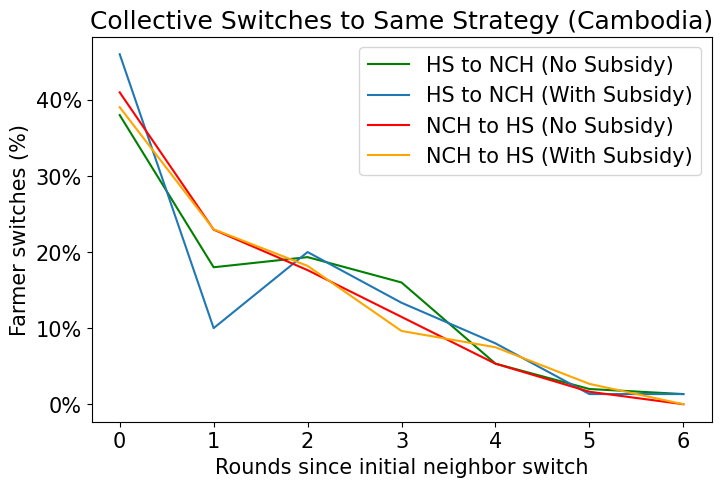

In [10]:
plt.rcParams.update({'font.size': 15})
# separating by country and subsidy
set_country("Cambodia")

switch_round=[0]*4
total_switches=[0]*11
switches=0
plt_arr=[[0]*7 for _ in range(4)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue 
    
    switches=0
    # subsidy=curr_csv['Subsidy'][i]
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    # curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==hs_2:
            if labels_2[(i+1)*4+j]!=hs_2:
                switches+=1

    if switches>1:
        plt_arr[subsidy][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy]+=switches
        recent_switch=curr_csv['Round'][i+1]

switch_round=[0]*4
# total_switches=0
switches=0
# plt_arr=[[0]*6 for _ in range(2)]
recent_switch=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        recent_switch=0
        continue
    switches=0
    subsidy=int(curr_csv['Subsidy'][i]>=1)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switches+=1
    if switches>1:
        plt_arr[subsidy+2][0]+=switches
        recent_switch=curr_csv['Round'][i+1]
        total_switches[subsidy+2]+=switches
    elif switches==1:
        if recent_switch!=0:
            plt_arr[subsidy+2][curr_csv['Round'][i+1]-recent_switch]+=switches
            total_switches[subsidy+2]+=switches
        recent_switch=curr_csv['Round'][i+1]


for i in range(4):
    for j in range(len(plt_arr[1])):
        plt_arr[i][j]/=total_switches[i]

labels=['HS to NCH (No Subsidy)', 'HS to NCH (With Subsidy)', 'NCH to HS (No Subsidy)', 
        'NCH to HS (With Subsidy)']

colors=['green', '#1f77b4', 'red', 'orange']
plt.figure(figsize=[8, 5])

for i in range(4):
    sns.lineplot(x=[_ for _ in range(len(plt_arr[i]))], y=plt_arr[i], 
                 label=labels[i], color=colors[i])
plt.xlabel("Rounds since initial neighbor switch")
plt.ylabel("Farmer switches (%)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.title("Collective Switches to Same Strategy (Cambodia)")
plt.savefig(join(directory, 'Figures', 'collective_switches_cambodia.png'), dpi=600, bbox_inches='tight')